In [8]:
#@Kawalya Davis
import os, shutil
import tensorflow.keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydicom
from PIL import Image
import cv2
import shutil

In [11]:
#get working directory
os.getcwd()

'/run/media/kawalya/TOSHIBA EXT/advanced-embedded-systems/automated_medical_diagnosis_of_radio_images'

In [10]:
#change working directory to where the datasets are
os.chdir('/run/media/kawalya/TOSHIBA EXT/advanced-embedded-systems/automated_medical_diagnosis_of_radio_images/')

In [ ]:
os.listdir()

In [12]:
#verify you are in the correct directory
os.getcwd()

'/run/media/kawalya/TOSHIBA EXT/advanced-embedded-systems/automated_medical_diagnosis_of_radio_images'

In [13]:
#Provide train, validation, and test to tensorflow-keras ImageDataGenerator
base_dir5_split = './radio_images_train_validate_test_dataset_binary'
base_dir5_train = './radio_images_train_validate_test_dataset_binary/train'
base_dir5_validate = './radio_images_train_validate_test_dataset_binary/validate'
base_dir5_test = './radio_images_train_validate_test_dataset_binary/test'


if not os.path.exists(base_dir5_split):
    os.mkdir(base_dir5_split)
if not os.path.exists(base_dir5_train):
    os.mkdir(base_dir5_train)
if not os.path.exists(base_dir5_split):
    os.mkdir(base_dir5_validate)
if not os.path.exists(base_dir5_test):
    os.mkdir(base_dir5_test)

In [14]:
#run tensorflow-keras ImageDataGenerator on the directory which contains train, validate and test
train_datagen = ImageDataGenerator(
    rescale=1./255, # new parameter (maps pixel values to floats)
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest') # Note: I added this, too

# The validation data should not be augmented (just rescaled)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        base_dir5_train,
        color_mode='rgb',
        target_size=(256, 256), 
        batch_size=32, 
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        base_dir5_validate, 
        color_mode='rgb',
        target_size=(256, 256), 
        batch_size=32, 
        class_mode='binary')

Found 5534 images belonging to 2 classes.
Found 1846 images belonging to 2 classes.


In [15]:
#load the root model and load trained weights into it
root_model = tensorflow.keras.applications.DenseNet121(weights=None,
                                     include_top=False,
                                     input_shape=(256,256,3),pooling="avg")
predictions_layer = layers.Dense(14,activation='sigmoid',name='predictions_layer')(root_model.output)
#using the functional API to add the layer defined above to the root model
root_model = tensorflow.keras.Model(inputs=root_model.input, outputs=predictions_layer)
#load weights into the root model
root_model.load_weights("./brucechou1983_CheXNet_Keras_0.3.0_weights.h5")
root_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

__________________________________________________________________________________________________
conv4_block3_1_conv (Conv2D)    (None, 16, 16, 128)  40960       conv4_block3_0_relu[0][0]        
__________________________________________________________________________________________________
conv4_block3_1_bn (BatchNormali (None, 16, 16, 128)  512         conv4_block3_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block3_1_relu (Activation (None, 16, 16, 128)  0           conv4_block3_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_block3_2_conv (Conv2D)    (None, 16, 16, 32)   36864       conv4_block3_1_relu[0][0]        
__________________________________________________________________________________________________
conv4_block3_concat (Concatenat (None, 16, 16, 352)  0           conv4_block2_concat[0][0]        
          

__________________________________________________________________________________________________
conv5_block12_1_relu (Activatio (None, 8, 8, 128)    0           conv5_block12_1_bn[0][0]         
__________________________________________________________________________________________________
conv5_block12_2_conv (Conv2D)   (None, 8, 8, 32)     36864       conv5_block12_1_relu[0][0]       
__________________________________________________________________________________________________
conv5_block12_concat (Concatena (None, 8, 8, 896)    0           conv5_block11_concat[0][0]       
                                                                 conv5_block12_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block13_0_bn (BatchNormal (None, 8, 8, 896)    3584        conv5_block12_concat[0][0]       
__________________________________________________________________________________________________
conv5_bloc

In [16]:
#chop five layers off the root_model
root_model = tensorflow.keras.Model(inputs=root_model.input, outputs=root_model.layers[-5].output)
root_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

__________________________________________________________________________________________________
conv4_block10_0_relu (Activatio (None, 16, 16, 544)  0           conv4_block10_0_bn[0][0]         
__________________________________________________________________________________________________
conv4_block10_1_conv (Conv2D)   (None, 16, 16, 128)  69632       conv4_block10_0_relu[0][0]       
__________________________________________________________________________________________________
conv4_block10_1_bn (BatchNormal (None, 16, 16, 128)  512         conv4_block10_1_conv[0][0]       
__________________________________________________________________________________________________
conv4_block10_1_relu (Activatio (None, 16, 16, 128)  0           conv4_block10_1_bn[0][0]         
__________________________________________________________________________________________________
conv4_block10_2_conv (Conv2D)   (None, 16, 16, 32)   36864       conv4_block10_1_relu[0][0]       
__________

Total params: 7,033,408
Trainable params: 6,951,808
Non-trainable params: 81,600
__________________________________________________________________________________________________


In [17]:
#freeze the conv_base of the root model
root_model.trainable = False

#create a new model whose lower layers constitute the frozen conv_base
model = models.Sequential()
model.add(root_model)

#add more layers to the new model
#you can choose any depending on the need at hand
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid',name='predictions'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Functional)         (None, 8, 8, 1024)        7033408   
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 1024)        4096      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 1024)        0         
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dropout (Dropout)            (None, 16384)             0         
_________________________________________________________________
predictions (Dense)          (None, 1)                 16385     
Total params: 7,053,889
Trainable params: 18,433
Non-trainable params: 7,035,456
_________________________________________

In [18]:
#compile with an optimizer or loss function
model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(learning_rate=0.0001), metrics=['acc'])

In [19]:
#fit the model to the data 
history = model.fit_generator(
      train_generator,
      steps_per_epoch=32,
      epochs=20,
      validation_data=validation_generator,
      validation_steps=32,
      verbose=1)

/home/kawalya/ml/env/lib64/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
32/32 [==============================] - 652s 20s/step - loss: 1.1359 - acc: 0.4825 - val_loss: 0.9553 - val_acc: 0.5811
Epoch 2/20
32/32 [==============================] - 604s 19s/step - loss: 1.0280 - acc: 0.5300 - val_loss: 0.7867 - val_acc: 0.5781
Epoch 3/20
32/32 [==============================] - 610s 19s/step - loss: 0.9805 - acc: 0.5313 - val_loss: 0.7680 - val_acc: 0.5693
Epoch 4/20
32/32 [==============================] - 603s 19s/step - loss: 0.9638 - acc: 0.5038 - val_loss: 0.7543 - val_acc: 0.5820
Epoch 5/20
32/32 [==============================] - 609s 19s/step - loss: 0.9292 - acc: 0.5320 - val_loss: 0.7382 - val_acc: 0.5732
Epoch 6/20
32/32 [==============================] - 607s 19s/step - loss: 1.0015 - acc: 0.4807 - val_loss: 0.7186 - val_acc: 0.5742
Epoch 7/20
32/32 [==============================] - 605s 19s/step - loss: 0.9623 - acc: 0.5222 - val_loss: 0.7322 - val_acc: 0.5684
Epoch 8/20
32/32 [==============================] - 609s 19s/step - loss: 0.

In [20]:
# should add smoothing to these plots
def plot_history(h):
    acc = h.history['acc']
    val_acc = h.history['val_acc']
    loss = h.history['loss']
    val_loss = h.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

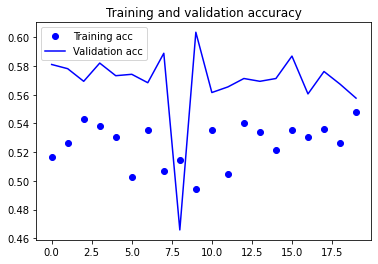

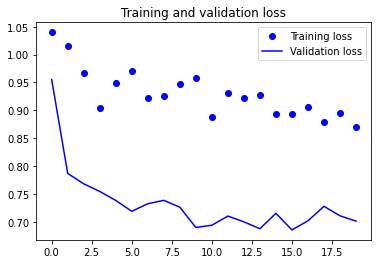

In [21]:
plot_history(history)

In [22]:
test_generator = test_datagen.flow_from_directory(
        base_dir5_test,
        color_mode='rgb',
        target_size=(256, 256), 
        batch_size=32, 
        class_mode='binary')

Found 1846 images belonging to 2 classes.


In [23]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=20)
test_acc

/home/kawalya/ml/env/lib64/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


0.614062488079071